各ライブラリのインポート

In [1]:
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import numpy as np

アルゴリズムのパラメータ

In [2]:
c = 343.    # speed of sound
fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_range = [300, 3500]

ルームの作成

(2, 10)


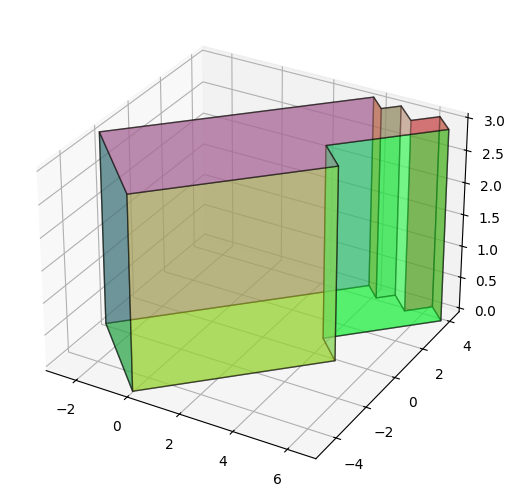

In [3]:
# ガウスノイズの設定
snr_db = 5.    # signal-to-noise ratio
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * 2.)**2

room_dim = [8, 6]

corners = None
flag = False
# 部屋の寸法
if flag:
    corners = np.array([[0,0], [0,6], [5,6], [5,3], [5.1,3], [5.1,6], [8,6], [8,0]]).T  # [x,y]
else:
    x = 11
    room_data = [[0,1.438],[0,2.368],[1,2.368],[1,3.438],[1.69,3.438],[1.69,4.3],[x,4.3],[x,0],[4.155,0],[4.155,1.438]]
    theta = -135
    theta = theta*np.pi/180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    room_data = np.array(room_data)
    room_data -= np.array([max(room_data[0])/2, max(room_data[1])/2])
    corners = np.dot(rot_mat, room_data.T).T
    corners = corners[:, ::-1]
    # linear_motion = np.array([4,6])
    linear_motion = np.array([6.5,3.1])
    corners += linear_motion
    corners = corners.T
print(corners.shape)

# 部屋をつくります
# fsは生成されるインパルス応答のサンプリング周波数です。入力する音源があるならそれに合わせる。
aroom = pra.Room.from_corners(corners, fs=fs, materials=None, max_order=3, sigma2_awgn=sigma2, air_absorption=True)
aroom.extrude(3.) # 高さ3m
fig, ax = aroom.plot()

マイクロフォンアレイを追加

In [4]:
# マイクを作成
center = [0,3]
mic_locs = pra.circular_2D_array(center=center, M=6, phi0=0, radius=0.1)
# z軸座標を追加 高さは0.3m
mic_locs_z = np.concatenate((mic_locs, np.ones((1, mic_locs.shape[1]))*0.3), axis=0)
print(mic_locs_z)
aroom.add_microphone_array(mic_locs_z)

[[ 0.1         0.05       -0.05       -0.1        -0.05        0.05      ]
 [ 3.          3.08660254  3.08660254  3.          2.91339746  2.91339746]
 [ 0.3         0.3         0.3         0.3         0.3         0.3       ]]


音源の追加

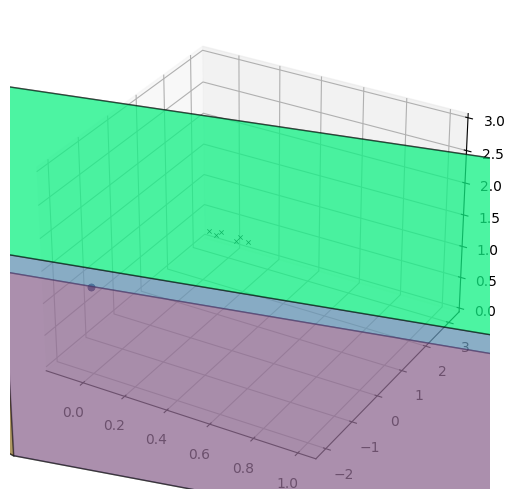

source.position:[ 0.  -2.   1.3]
n_sources:19


In [5]:
# 音源を作成
from scipy.io import wavfile
_, audio = wavfile.read('./SoundSource/sound_source.wav')
sound_locations = np.array([0., -2.])
sound_locations_z = np.array([0., -2., 1.3])
aroom.add_source(sound_locations_z, signal=audio)
# aroom.add_source(sound_locations_z[1], signal=audio)
fig, ax = aroom.plot()
# グラフのz軸を3mまでに制限
ax.set_zlim([0, 3])
plt.show()
# Run the simulation
aroom.simulate()

DOAにはSTFT入力が必要

In [6]:
X = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)
X = X.transpose([2, 1, 0])

In [7]:
# Construct the new DOA object
# the max_four parameter is necessary for FRIDA only
doa = pra.doa.algorithms['MUSIC'](mic_locs, fs, nfft, c=c, num_src=2, max_four=4)

# this call here perform localization on the frames in X
doa.locate_sources(X, freq_range=freq_range)

# store spatial response
spatial_resp = doa.grid.values

# normalize   
min_val = spatial_resp.min()
max_val = spatial_resp.max()
#spatial_resp = (spatial_resp - min_val) / (max_val - min_val) # normalize to 0-1
spatial_resp = (spatial_resp) / (max_val) # normalize to 0-1

空間スペクトルをプロット

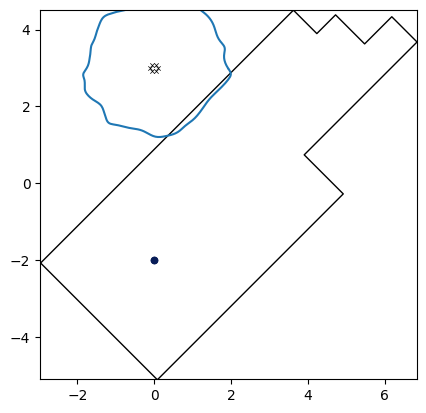

In [8]:
aroom = pra.Room.from_corners(corners)
# マイクをプロット
aroom.add_microphone_array(mic_locs)
# 音源をプロット
aroom.add_source(sound_locations)
fig, ax = aroom.plot()
# spacial_respを直交座標系に変換
angles = np.array([np.cos(doa.grid.azimuth), np.sin(doa.grid.azimuth)]).T
spatial_reshaped = spatial_resp.reshape(-1,1)
size = 2
point_list = spatial_reshaped * angles * size + center
ax.plot(point_list[:, 0], point_list[:, 1], '-')
plt.show()

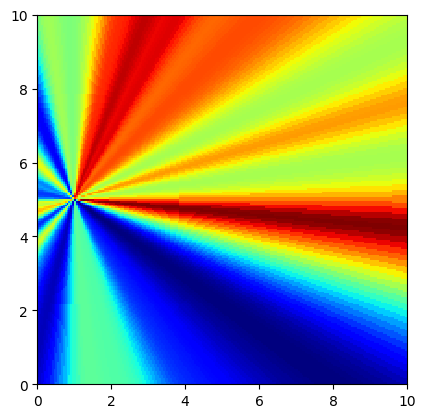

In [9]:
data = spatial_resp
max_field = 10
# Define the grid spacing
spacing = 0.05
# Calculate the number of points in each dimension
num_points = int(max_field / spacing)
# Create the grid
grid = np.zeros((num_points, num_points))

# 各グリッドの座標の中心点を計算
x = np.arange(0, max_field, spacing) + spacing / 2
y = np.arange(0, max_field, spacing) + spacing / 2
points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
center_ = [max_field/2 - room_dim[0]/2 + center[0], max_field/2 - room_dim[1]/2 + center[1]]
# 各点について、マイクロフォンアレイの座標からの角度を計算
angles = np.arctan2(points[:,1] - center_[1], points[:,0] - center_[0])*180/np.pi
# 小数点以下を四捨五入
angles = np.round(angles)
# 0から360度までの範囲にする
angles[angles < 0] += 360

# gridの各点について、anglesの値番目のdataを代入
for i, angle in enumerate(angles):
    grid[int(points[i,0]/spacing), int(points[i,1]/spacing)] = data[int(angle)]
# gridをプロット
plt.imshow(grid.T, cmap='jet', interpolation='nearest', extent=[0, max_field, 0, max_field], origin='lower')